In this experiment you will generate traffic using OSNT, an open source network tester, and capture it with DAG.  <img src="alt_setup2.1.jpg">
###### Setup:  

First time use:   
-- `mkdir <crsid>` (Machine B)     
-- `git clone https://github.com/cucl-srg/L50` (Machine B)     
-- `wget https://www.cl.cam.ac.uk/research/srg/netos/projects/netfpga/bitfiles/OSNT-SUME-live/osnt_20170129.bit -P /root/<crsid>/L50/setup` (Machine B)   
-- `bash /root/<crsid>/L50/setup/load_osnt_bitfile.sh <crsid>` (Machine B)   
-- reboot the machine (also required after Machine B was powered down)

Repeated use:   
-- `bash /root/<crsid>/L50/setup/load_osnt_bitfile.sh <crsid>` (Machine B)   
-- `dagload` (Machine A)   
-- `bash /root/<crsid>/L50/setup/mkdir2.sh <crsid>` (Machine A)   
-- eval `ssh-agent -s` (Machine A, Note the \` before ssh and after -s)    
-- `ssh-add` (Machine A)    
-- Connect nf0 (B,tx) to dag0 (A,rx) via the tap. Leave dag1 (A,rx) unconnected.      
<img src="tap2.1_disconnect.jpg">

dagsnap is the capture tool. There cannot be more than one capture process running at the same time -- `pkill dagsnap` if there are any.  
  
###### Usage:  
  
`dagsnap -d0 -o <output file name>`  
This runs until it is killed.  
dagsnap produces .erf files. These can be viewed using Wireshark or converted to plaintext by `tshark -r file.erf [Optional: -V]`.   

E.g., Scripting a capture in Python
```
cmd = shlex.split('dagsnap -d0 -o output.erf')
p = Popen(cmd)
sleep(2) # ensure that process is ready to capture
# generate traffic #
p.kill()
```
The Popen module allows us to spawn a child process. For more information, read Python docs on the [Popen constructor](https://docs.python.org/2/library/subprocess.html#popen-constructor) and [Popen objects](https://docs.python.org/2/library/subprocess.html#popen-objects).  

In [2]:
crsid='jlf60'
%run /root/$crsid/L50/Jupyter/useful/useful.py
%run /root/$crsid/L50/Jupyter/useful/useful2.1.py
%matplotlib inline
machB_ip = '128.232.82.64' # UPDATE THIS

The function `send` will be used throughout this Notebook:  
Traffic will be generated from NetFPGA (Machine B) using OSNT. Capture it on the DAG card (Machine A) and check that these are correctly saved to L50Lab2/2.1.  

In [3]:
def send(exp,num,ipg=0):
    
    # start capture to /root/L50Lab2/2.1/'+exp+'.erf
    cmd = shlex.split('dagsnap -d0 -o /root/'+crsid+'/L50Lab2/2.1/'+exp+'.erf')
    p = Popen(cmd)
    sleep(2)
    
    ssh = ssh_connect(machB_ip)
    ssh_cmd('cd /root/OSNT-SUME-live/projects/osnt/sw/host/app/cli && python osnt-tool-cmd.py '
            '-ifp0 /root/'+crsid+'/L50/pcap_files/512.cap -rpn0 '+str(num)+' -ipg0 '+str(ipg)+' -run'
            ,ssh) # generate traffic
    ssh.close()
    sleep(5) # ensure that traffic has finished sending
    
    # end capture
    p.kill()

### Experiment a

We first check that the setup is connected and operating properly.
Send 1000 packets, size 512B. Check that the tool receives them. 
What is the precision of the measurement? What is the resolution?

In [7]:
%%capture
send('exp1a',1000)
!tshark -r /root/$crsid/L50Lab2/2.1/exp1a.erf -V | grep -e "since reference" > \
/root/$crsid/L50Lab2/2.1/exp1a.txt

In [8]:
times = gettimes('exp1a',crsid)
print "Packets received: " + str(len(times)) + "\n"
for i in range(10):
    print str(times[i]) + " seconds"
print "..."

Packets received: 1000

0.000000000 seconds
0.000000432 seconds
0.000000856 seconds
0.000001288 seconds
0.000001716 seconds
0.000002148 seconds
0.000002572 seconds
0.000003004 seconds
0.000003432 seconds
0.000003856 seconds
...


### Experiment b

Connect dag1 to the tap. <img src="tap2.1_connect.jpg" />

Send 100000 packets, size 512B, nf0 (B) to dag0 (A) and dag1 (A). What is the difference between the ports?

In [13]:
%%capture
send('exp1b',150000)
!tshark -r /root/$crsid/L50Lab2/2.1/exp1b.erf -V | grep -e "since reference" -e "Interface id"> \
/root/$crsid/L50Lab2/2.1/exp1b.txt

Plot a histogram of (dag0 TS - dag1 TS):

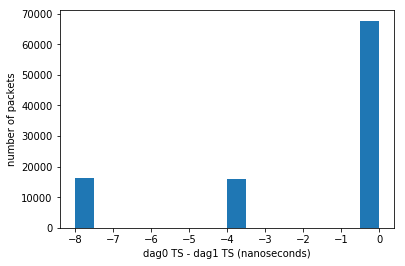

In [8]:
def cmp_ports(exp,crsid):
    diff = getdiff(exp,crsid)
    diff = [round(d) for d in diff]
    minn = int(floor(min(diff)))
    maxx = int(ceil(max(diff)))
    plt.hist(diff,abs(maxx-minn)*2,range=(minn,maxx))
    plt.xlabel("dag0 TS - dag1 TS (nanoseconds)")
    plt.ylabel("number of packets")
    plt.show()
cmp_ports('exp1b',crsid)

### Experiment c

Swap the transceivers and fibres, and repeat Experiment 2.

In [21]:
%%capture
send('exp1c',150000)
!tshark -r /root/$crsid/L50Lab2/2.1/exp1c.erf -V | grep -e "since reference" -e "Interface id"> \
/root/$crsid/L50Lab2/2.1/exp1c.txt

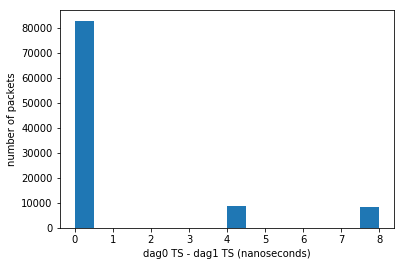

In [6]:
cmp_ports('exp1c',crsid)